# Tinycardia: Lightweight Cardiac Emergency Diagnosis on Microcontroller (STM32)

Tinycardia aims to detect atrial fibrillation (AFib) from ECG signals using machine learning models small enough to run on resource-constrained microcontrollers like the STM32. By combining high-quality ECG data from the PTB-XL dataset with smart preprocessing and efficient model design, Tinycardia brings reliable heart rhythm monitoring to low-power wearable and portable devices.



# Part 1: Loading the Dataset

Tinycardia uses the PTB-XL dataset, one of the best open ECG collections out there, with over 21,000 recordings from real patients. Tinycardia focuses on classifying sinus rhythms versus atrial fibrillation. PTB-XL is perfect since it  contains high-quality signals, detailed labels, and a wide variety of patient data to train on.

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [3]:
from google.colab import drive

# mount to google drive
drive.mount('/content/drive', force_remount=True)

# copy zip file to colab vm
!cp "/content/drive/MyDrive/datasets/ptb-xl.zip" /content/

# unzip locally (higher speed than gdrive)
!unzip -q /content/ptb-xl.zip -d /content/ptb-xl

Mounted at /content/drive


In [4]:
# sanity check: make sure everything in the dataset exists
!ls /content/ptb-xl/

example_physionet.py  ptbxl_database.csv  records100  scp_statements.csv
LICENSE.txt	      RECORDS		  records500  SHA256SUMS.txt


In [5]:
import pandas as pd
import ast

# path to our dataset
path = '/content/ptb-xl/'

# put dataset in dataframe
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

# translate from string to dictionary for parsing
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)

# highest quality labels are those provided by cardiologists
Y = Y[Y.validated_by_human]

Y['scp_codes'].head()

,scp_codes
ecg_id,
1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"
2,"{'NORM': 80.0, 'SBRAD': 0.0}"
3,"{'NORM': 100.0, 'SR': 0.0}"
4,"{'NORM': 100.0, 'SR': 0.0}"
5,"{'NORM': 100.0, 'SR': 0.0}"


In [6]:
# after several rounds of testing and based on real-world wearable devices like Apple Watch, i concluded this is the only reliable classification
# we include all of the sinus-type rhythms in one class (even arrhythmia) because you cannot draw medical inference from individual classification, so no need to alert the user here.
rhythm_map = {
    "NORM": 'sinus normal',
    'SR':   'sinus normal',
    'SARRH':'sinus normal',
    'SBRAD':'sinus normal',
    'STACH':'sinus normal',
    'AFIB': 'atrial fibrillation' # afib is the most dangerous rhythm type as it leads to further issues like stroke, heart failure, etc
}

# we will parse the scp_codes dict from earlier
def get_rhythm_label(codes):
    for code, label in rhythm_map.items():
        if any(key.startswith(code) for key in codes.keys()):
            return label
    return None

# clean copy for safety
Y = Y.copy()

# now use .loc to force pandas to write into the frame
Y.loc[:, 'rhythm'] = Y['scp_codes'].apply(get_rhythm_label)

# drop any rows where the code didn't work
Y = Y.dropna(subset=['rhythm'])

# class imbalance debug
Y['rhythm'].value_counts()

,count
rhythm,
sinus normal,14467
atrial fibrillation,963


As you can see there is a very high class imbalance. This is natural because humans will have a normal rhythm more often than not (as is essential to life).

If we do not fix this class imbalance, the model will learn to cheat the system for high accuracy by guessing the dominant class all the time (oversimplification, but that's basically how it works).

To fix this, we will duplicate the non dominant class data, and add time-aware augmentations like time warping, jitter, and smoothing. This will help reduce overfitting as well.

We only want to apply the oversampling to the training set. We do not want to touch the validation set. This needs to be the ground truth data, so modifying it in any way is clearly risky.

# Part 2: Feature Extraction and Fixing Class Imbalance

From the last section, we have a very large class imbalance. We need to fix this before we train our model. To do this we will oversample the minority class using duplication with time aware augmentation techniques. If we do not fix this, our model will ignore our minority class and just predict the dominant class to cheat the accuracy metric. We will also extract R-wave timing-based features since 1DCNN otherwise has a difficult time handling temporal aspect of the data occasionally necessary for our classification problem.

## Pan-Tompkins QRS complex detection

To extract the R-wave timing-based features, we first need to correctly identify the emergence of the R-wave. There are many rudimentary heuristics that can be used such as find_peaks in Scipy, but none have as well known of a history compared to the Pan-Tompkins algorithm. The Pan-Tompkins algorithm is known for low computational cost while retaining high accuracy, making it ideal for embedded systems applications.

The Pan-Tompkins algorithm works in 5 steps:

*   Bandpass filter: Remove baseline wander & high-frequency noise
*   Differentiation: Highlight steep slopes of the ECG signal
*   Squaring: Square the function to make all data positive and emphasize larger offsets
*   Smoothing: 150ms window used to smooth signal and create waveform for peak analysis
*   Thresholding: Adaptive thresholds to detect true QRS complexes, distinguishing real heartbeats from noise or other artifacts.



In [7]:
def pan_tompkins_qrs_detect(signal, fs):
    diff = np.diff(signal, prepend=signal[0])
    squared = diff ** 2

    win_size = int(0.15 * fs)
    integrated = np.convolve(squared, np.ones(win_size)/win_size, mode='same')

    threshold = np.mean(integrated) + 0.7 * np.std(integrated)
    potential_peaks = np.where(integrated > threshold)[0]

    min_distance = int(0.78 * fs)  # allows for about a maximum heart rate of 300

    peaks = []
    last_peak = -np.inf

    for idx in potential_peaks:
        if idx - last_peak > min_distance:
            peaks.append(idx)
            last_peak = idx

    peaks = np.array(peaks)

    return peaks

## RR interval timing-based feature extraction

Our key goal for this system is to distinguish atrial fibrillation from sinus rhythms.

* AFib: Chaotic, irregular, no repeating RR interval pattern
* Sinus rhythm: Regular (no matter the speed), consistent RR interval

Therefore, if we can quantify regularity and variability of the RR interval, we have very powerful discriminators for our two classes.

In [8]:
import numpy as np
from scipy.signal import welch

def compute_rr_features(rpeaks_samples, fs):
    # convert sample‐indices to ms intervals
    rr_intervals = np.diff(rpeaks_samples) / fs * 1000

    if len(rr_intervals) < 2:
        return np.zeros(7, dtype=float)

    # time‐domain extracted features
    mean_rr = np.mean(rr_intervals)
    sdnn    = np.std(rr_intervals, ddof=1)
    diff1   = np.diff(rr_intervals)
    rmssd   = np.sqrt(np.mean(diff1**2))
    pnn50   = np.sum(np.abs(diff1) > 50) / len(diff1)
    pnn20   = np.sum(np.abs(diff1) > 20) / len(diff1)

    # Poincare plot metrics
    var_rr   = np.var(rr_intervals)
    var_diff = np.var(diff1)
    sd1 = np.sqrt(var_diff / 2.0)
    sd2_sq = 2 * var_rr - var_diff / 2.0
    sd2   = np.sqrt(sd2_sq) if sd2_sq > 0 else 0.0

    # assemble and sanitize
    features = np.array([mean_rr, sdnn, rmssd, pnn50, pnn20, sd1, sd2], dtype=float)

    return features

## Resampling, normalization, feature extraction calls

Basically here I am just processing the data, resampling from 500Hz to 256Hz to fit the ECG front end read rate, normalizing the signal, detecting the QRS complexes, and extracting the RR features from that. This code prepares us to mask data into train and test sets.

In [9]:

from scipy.signal import resample
import numpy as np
import wfdb

fs_target = 256
window_length = fs_target * 10 # 10 seconds at 256Hz

signals = []
rr_features = []

for fn in Y.filename_hr:
    # read signal and metadata
    sig, meta = wfdb.rdsamp(path + fn)

    # pick lead II (this is the device electrode configuration)
    lead_idx = meta['sig_name'].index('II')
    x        = sig[:, lead_idx]

    # resample to 256Hz from 500Hz
    new_len = int(len(x) * fs_target / meta['fs'])
    x_rs    = resample(x, new_len)

    # if we have at least one 10s window worth of samples
    if len(x_rs) >= window_length:
        w = x_rs[:window_length]

        # normalize
        mean = np.mean(w)
        std = np.std(w)
        if std < 1e-6:
           std = 1e-6
        w = (w - mean) / std

        signals.append(w)

        # QRS complex detection
        peaks = pan_tompkins_qrs_detect(w, fs_target)

        # compute RR features
        rr_feat = compute_rr_features(peaks, fs_target)
        rr_features.append(rr_feat)

# stack into (N_windows, window_length)
signals = np.stack(signals)
rr_features = np.stack(rr_features)

signals.shape, rr_features.shape, np.mean(signals[0]), np.std(signals[0])

((15430, 2560), (15430, 7), np.float64(5.551115123125783e-18), np.float64(1.0))

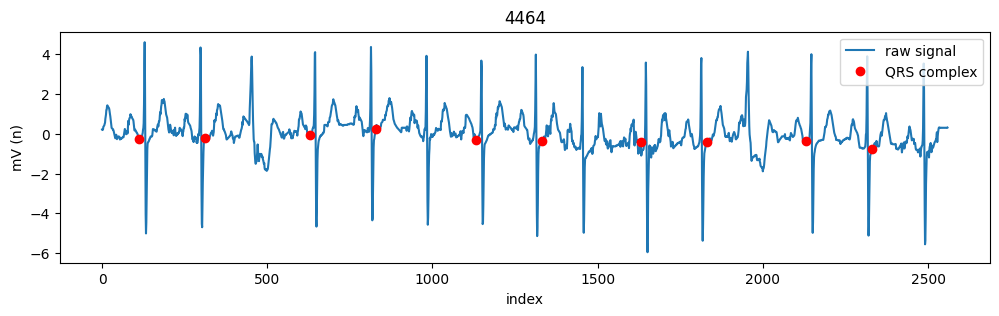

RR features: [962.67361111 216.0310862  409.14122917   1.           1.
 289.30653761   0.        ]


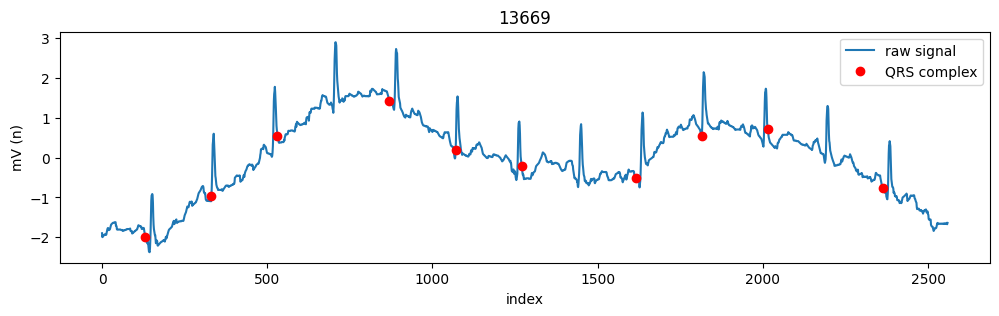

RR features: [9.68750000e+02 2.81392379e+02 4.42364488e+02 6.25000000e-01
 6.25000000e-01 3.08596840e+02 2.13390266e+02]


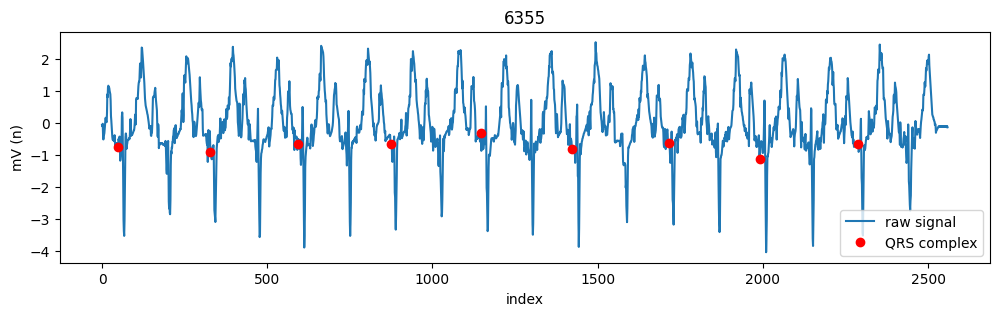

RR features: [1.09375000e+03 4.20197558e+01 6.24302066e+01 7.14285714e-01
 8.57142857e-01 4.36910248e+01 3.43656679e+01]


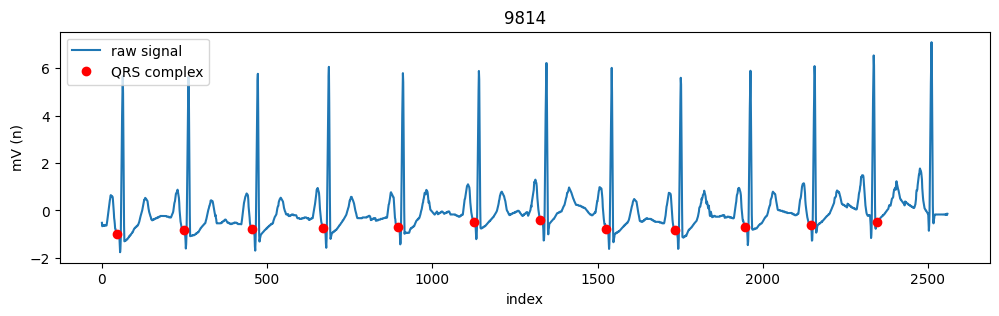

RR features: [8.16406250e+02 4.11178043e+01 4.29332240e+01 1.00000000e-01
 6.00000000e-01 3.03583738e+01 4.63931197e+01]


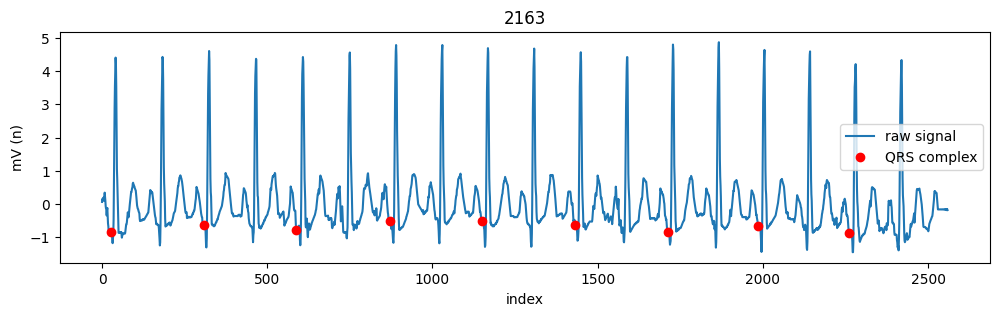

RR features: [1.09082031e+03 1.68014165e+01 2.20970869e+01 0.00000000e+00
 2.85714286e-01 1.53028004e+01 1.61191685e+01]


In [10]:
import matplotlib.pyplot as plt

# sanity check: plot random windows and features to ensure consistency
n_plot = min(5, signals.shape[0])
indices = np.random.choice(signals.shape[0], n_plot, replace=False)

for i, idx in enumerate(indices):
    window = signals[idx]

    # Run Pan-Tompkins
    peaks = pan_tompkins_qrs_detect(window, fs_target)

    plt.figure(figsize=(12, 3))
    plt.plot(window, label='raw signal')
    plt.plot(peaks, window[peaks], 'ro', label='QRS complex')
    plt.title(f"{idx}")
    plt.xlabel("index")
    plt.ylabel("mV (n)")
    plt.legend()
    plt.show()

    # print RR features for that window
    rr_feat = compute_rr_features(peaks, fs_target)
    print(f"RR features:", rr_feat)


# Part 3: Training the Model

We will use a 1DCNN concatenated with a dense layer. This allow extraction of morphological information through 1DCNN and extraction of temporal information through dense layer (time-based statistics). This allow us to better differentiate AFib from Sinus compared to just one or the other.

## Preprocessing

In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# reshape signals to add channel dimension
# basically the trailing dimension says that this is a batch of signals
X_all = signals[..., np.newaxis]  # shape (N_windows, window_length, channels)

# encode rhythms
le = LabelEncoder()
le.fit(Y['rhythm'])
y_all = le.transform(Y['rhythm'].values)

# train-test split
train_mask = (Y.strat_fold != 10).values
test_mask  = (Y.strat_fold == 10).values # according to PTB-XL docs we should use this masking

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

RR_train, RR_test = rr_features[train_mask], rr_features[test_mask]

# standardize RR features
# later we need to save these so we can replicate the same scaling on the MCU
# otherwise we will get poor inferencing on the MCU
scaler = StandardScaler().fit(RR_train) # fit only on train
RR_train = scaler.transform(RR_train)
RR_test  = scaler.transform(RR_test)

# print shapes for confirmation
print("X train shape:", X_train.shape)
print("X test shape:", X_test.shape)
print("RR train shape:", RR_train.shape)
print("RR test shape:", RR_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)


X train shape: (13340, 2560, 1)
X test shape: (2090, 2560, 1)
RR train shape: (13340, 7)
RR test shape: (2090, 7)
y train shape: (13340,)
y test shape: (2090,)


## Oversampling

Here we are duplicating data points with some noise to fix the class imbalance issue. This is a must otherwise as I said before, the model will learn to guess the majority class all the time, which is a trivial solution.

In [12]:
from collections import Counter
import numpy as np
import pandas as pd

# random noise to singal
def add_jitter(signal, sigma=0.02):
    return signal + np.random.normal(loc=0., scale=sigma, size=signal.shape)

# time-stretch factor on signal
def scale_signal(signal, scale_range=(0.8, 1.2)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale_factor

# this is generated by LLM
# my smoothing function kept breaking for some reason
# but this one works pretty well
def smooth_signal(signal, window_size=5):
    signal = np.asarray(signal)
    if signal.ndim == 1:
        rolled = pd.Series(signal).rolling(window=window_size, center=True).mean()
        return np.where(np.isnan(rolled), signal, rolled)
    elif signal.ndim == 2:
        smoothed = np.apply_along_axis(
            lambda x: np.where(
                np.isnan(pd.Series(x).rolling(window=window_size, center=True).mean()),
                x,
                pd.Series(x).rolling(window=window_size, center=True).mean()
            ),
            axis=0, arr=signal
        )
        return smoothed
    else:
        raise ValueError("broken")

def oversample(X, y, RR_features, augment=False, rr_sigma=0.1):
    cnt = Counter(y)
    max_count = max(cnt.values())
    indices_per_class = {cls: np.where(y==cls)[0] for cls in cnt}

    X_new, RR_new, y_new = [], [], []

    for cls, idxs in indices_per_class.items():
        # keep all original
        for i in idxs:
            sig = X[i].squeeze()
            sig = smooth_signal(sig)
            X_new.append(sig)
            RR_new.append(RR_features[i])
            y_new.append(cls)

        # augment data
        for _ in range(max_count - len(idxs)):
            orig_idx = np.random.choice(idxs)
            sig_aug = X[orig_idx].squeeze()

            # signal
            if augment:
                sig_aug = smooth_signal(sig_aug)
                sig_aug = add_jitter(sig_aug)
                sig_aug = scale_signal(sig_aug)

            # RR feature
            rr_aug = RR_features[orig_idx].copy()
            if augment:
                noise = np.random.normal(loc=0.0, scale=rr_sigma, size=rr_aug.shape)
                rr_aug = rr_aug + noise

            X_new.append(sig_aug)
            RR_new.append(rr_aug)
            y_new.append(cls)

    # stack back into arrays
    X_oversampled  = np.stack(X_new)[..., np.newaxis]
    RR_oversampled = np.stack(RR_new)
    y_oversampled  = np.array(y_new, dtype=np.int32)

    return X_oversampled, RR_oversampled, y_oversampled

# usage for training set:
X_train, RR_train, y_train = oversample(
    X_train, y_train, RR_train,
    augment=True,
    rr_sigma=0.05 # 5% noise on each RR feature
)

print("after oversampling", Counter(y_train))
print(X_train.shape, RR_train.shape, y_train.shape)

after oversampling Counter({np.int32(1): 12526, np.int32(0): 12526})
(25052, 2560, 1) (25052, 7) (25052,)


## Model architecture

The model has two branches: convolutional branch that handles the raw waveforms, and dense branch to handle the RR features. By merging the branches we obtain both morphological information from the convolutional branch, and temporal information (summarized via stats) through the dense branch. This approach significantly increases our capability to differentiate AFib from Sinus rhythm compared to just one of either branch.

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Input, Model

l2 = 1e-3
dr = 0.3
n_classes = Y['rhythm'].nunique()

ecg_in = Input(shape=(2560,1), name="ecg_signal") # 10s @256Hz
rr_in  = Input(shape=(7,),    name="rr_features") # 7 RR features

# convolutional branch
x = layers.Conv1D(16, 7, activation="relu", padding="same",
                  kernel_regularizer=regularizers.l2(l2))(ecg_in)
x = layers.MaxPool1D(4)(x)
x = layers.Conv1D(32, 15, activation="relu", padding="same",
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.MaxPool1D(4)(x)
x = layers.Conv1D(64, 31, activation="relu", padding="same",
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dr)(x)

# dense layer branch
y = layers.Dense(32, activation="relu",
                 kernel_regularizer=regularizers.l2(l2))(rr_in)
y = layers.Dropout(dr)(y)

# concatenate the layers
z = layers.Concatenate()([x,y])
z = layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.l2(l2))(z)
z = layers.Dropout(dr)(z)
logits = layers.Dense(n_classes, name="logits")(z)
probs  = layers.Activation("softmax", name="probs")(logits)

model = Model([ecg_in, rr_in], probs)

# compile before training
model.compile(
  optimizer="adam",
  loss="categorical_crossentropy",
  metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_signal          │ (None, 2560, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2560, 16)  │        128 │ ecg_signal[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 640, 16)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 640, 32)   │      7,712 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 160, 32)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 160, 64)   │     63,552 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr_features         │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        256 │ rr_features[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 2)         │        130 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ probs (Activation)  │ (None, 2)         │          0 │ logits[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 77,986 (304.63 KB)

 Trainable params: 77,986 (304.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from keras.utils import to_categorical

# here we are converting into 1hot encoded vector so we can use it in our model
# because our model expect categorical target due to our loss function selection
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

y_train_cat.shape, y_test_cat.shape

((25052, 2), (2090, 2))

In [15]:
# train our model with early return if validation loss is not improving over time
# this balances accuracy with training time tradeoff
history = model.fit(
  x=[X_train, RR_train],
  y=y_train_cat,
  validation_data=([X_test, RR_test], y_test_cat),
  batch_size=32,
  epochs=50,
  callbacks=[tf.keras.callbacks.EarlyStopping("val_loss", patience=5, restore_best_weights=True)]
)

Epoch 1/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8685 - loss: 0.4187 - val_accuracy: 0.9368 - val_loss: 0.2556
Epoch 2/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9527 - loss: 0.2031 - val_accuracy: 0.9249 - val_loss: 0.2852
Epoch 3/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9663 - loss: 0.1583 - val_accuracy: 0.9072 - val_loss: 0.3207
Epoch 4/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9704 - loss: 0.1408 - val_accuracy: 0.7670 - val_loss: 0.7733
Epoch 5/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9720 - loss: 0.1303 - val_accuracy: 0.7665 - val_loss: 0.7990
Epoch 6/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9773 - loss: 0.1176 - val_accuracy: 0.8981 - val_loss: 0.4348


## Training results

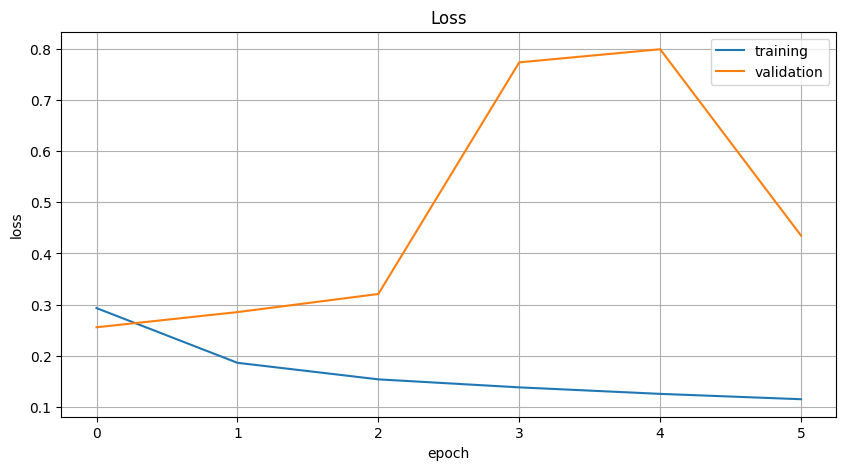

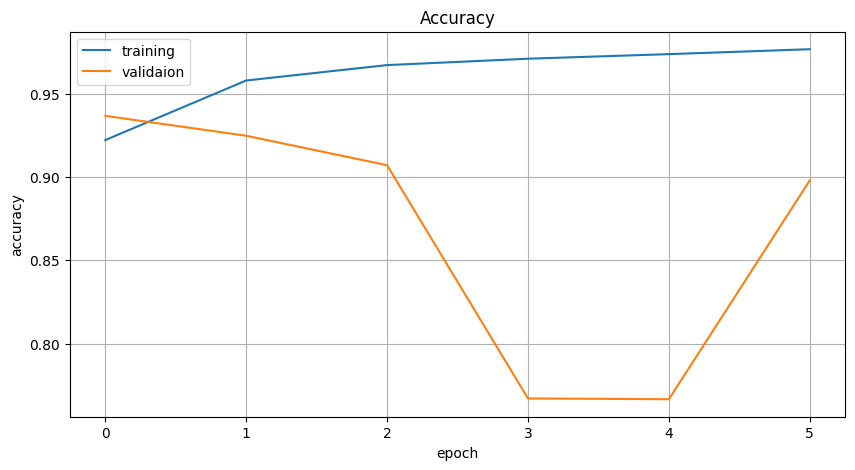

In [16]:
# plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

# plot training and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validaion')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


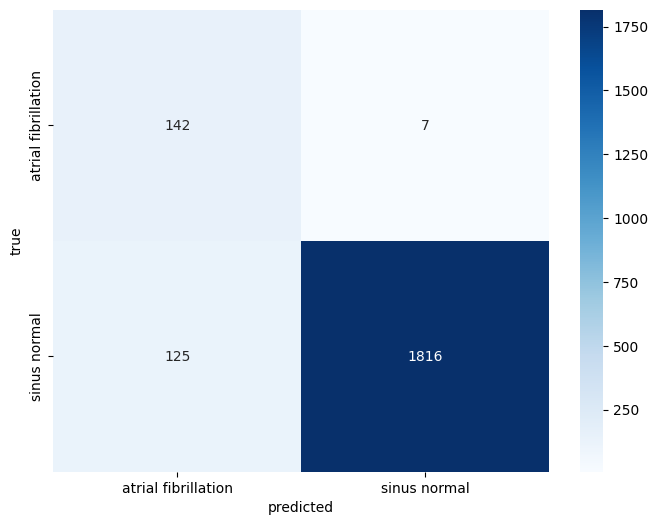

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# get predictions for the test set
y_pred_cat = model.predict([X_test, RR_test])
#y_pred_cat = model.predict(RR_test)

# convert 1hot to class labels
y_pred = np.argmax(y_pred_cat, axis=1)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

As you can see from our confusion matrix, we have quite the performant model. There are clearly some false positives for AFib. This could be improved on, however it's arguably fine to leave this as well. In a medical context, it is safer to false flag AFib than leave it undetected.

What really matters here is that the recall for AFib is fantastic, nearly 98%. This makes sure we almost never miss an AFib rhythm, leading to higher diagnoses. Missing an AFib rhythm is risky, as the implications of AFib include stroke, heart failure, coronary artery disease, high blood pressure, and valve problems.

# Part 4: Save quantized model for MCU deployment

It's important to quantize the model to deploy on the MCU because it will reduce the flash and RAM footprint and fit within the size constraints of the MCU. It will also speed up inference since integer math is more efficient.

In [18]:
import tensorflow as tf
import numpy as np

# clear session to be safe
tf.keras.backend.clear_session()

# make representative dataset generator
def representative_dataset():
    for ecg_batch, rr_batch in zip(X_train[:100], RR_train[:100]):
        ecg = np.expand_dims(ecg_batch, axis=0).astype(np.float32)
        rr  = np.expand_dims(rr_batch,  axis=0).astype(np.float32)
        yield {
          "ecg_signal": ecg,
          "rr_features": rr
        }

# set up the converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# quantization for both weights and activations
converter.target_spec.supported_ops    = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type         = tf.int8
converter.inference_output_type        = tf.int8

# save model
tflite_model = converter.convert()
with open("afib_detector_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("model saved")

Saved artifact at '/tmp/tmprpxnlwe8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 2560, 1), dtype=tf.float32, name='ecg_signal'), TensorSpec(shape=(None, 7), dtype=tf.float32, name='rr_features')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139284767547920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284767550800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284767552720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284767552144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284767554640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284767552912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284767554832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284767555408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284763771920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139284763773264: 

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


model saved
